In [1]:
# Let`s import all packages that we may need:

import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.model_selection import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score

import keras
from keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Dropout
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
import itertools

In [2]:
df = pd.read_csv('/Users/hardiksharma/Downloads/household_power_consumption.txt', sep=';', 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')

/var/folders/yb/8jhwh7cn235d199bqshp07680000gn/T/ipykernel_50714/1065913916.py:1: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv('/Users/hardiksharma/Downloads/household_power_consumption.txt', sep=';',
/var/folders/yb/8jhwh7cn235d199bqshp07680000gn/T/ipykernel_50714/1065913916.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv('/Users/hardiksharma/Downloads/household_power_consumption.txt', sep=';',
/var/folders/yb/8jhwh7cn235d199bqshp07680000gn/T/ipykernel_50714/1065913916.py:1: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a fo

In [6]:
df.head()
df.shape

(2075259, 7)

In [7]:
# Assuming 'df' is your DataFrame
# Filter rows with any NaN values
nan_rows = df[df.isna().any(axis=1)]

# Display the first 5 rows with NaN values
print(nan_rows.head(5))

                     Global_active_power  Global_reactive_power  Voltage  \
dt                                                                         
2006-12-21 11:23:00                  NaN                    NaN      NaN   
2006-12-21 11:24:00                  NaN                    NaN      NaN   
2006-12-30 10:08:00                  NaN                    NaN      NaN   
2006-12-30 10:09:00                  NaN                    NaN      NaN   
2007-01-14 18:36:00                  NaN                    NaN      NaN   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
dt                                                                      
2006-12-21 11:23:00               NaN             NaN             NaN   
2006-12-21 11:24:00               NaN             NaN             NaN   
2006-12-30 10:08:00               NaN             NaN             NaN   
2006-12-30 10:09:00               NaN             NaN             NaN   
2007-01-14 18:36:00          

In [8]:
df = df.dropna()

df.shape

(2049280, 7)

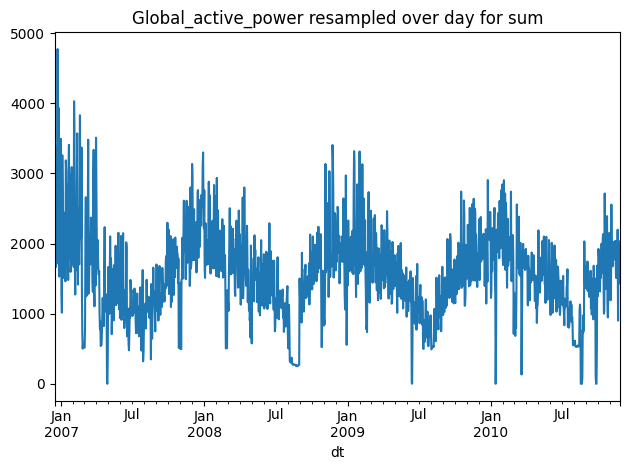

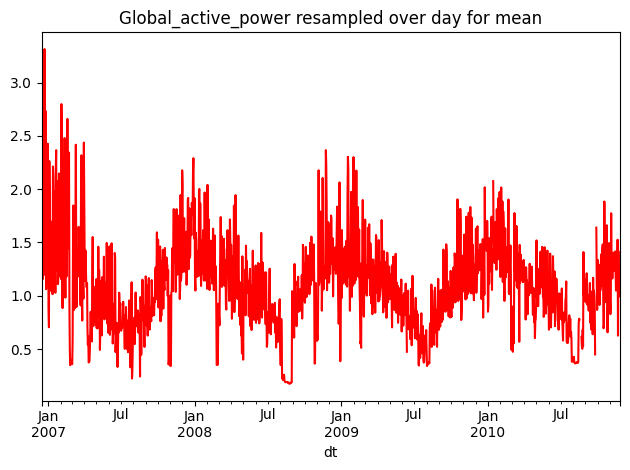

In [9]:
df.Global_active_power.resample('D').sum().plot(title='Global_active_power resampled over day for sum') 
#df.Global_active_power.resample('D').mean().plot(title='Global_active_power resampled over day', color='red') 
plt.tight_layout()
plt.show()   

df.Global_active_power.resample('D').mean().plot(title='Global_active_power resampled over day for mean', color='red') 
plt.tight_layout()
plt.show()

In [10]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [11]:
## resampling of data over hour
df_resample = df.resample('h').mean() 
df_resample.shape

(34589, 7)

In [12]:
## * Note: I scale all features in range of [0,1].

## If you would like to train based on the resampled data (over hour), then used below
values = df_resample.values 


## full data without resampling
#values = df.values

# integer encode direction
# ensure all data is float
#values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.636816   0.295738   0.337945   0.631157        0.0   0.011366   
2   0.545045   0.103358   0.335501   0.541487        0.0   0.144652   
3   0.509006   0.110073   0.283802   0.502152        0.0   0.030869   
4   0.488550   0.096987   0.315987   0.481110        0.0   0.000000   
5   0.455597   0.099010   0.434417   0.449904        0.0   0.008973   

   var7(t-1)   var1(t)  
1   0.782418  0.545045  
2   0.782676  0.509006  
3   0.774169  0.488550  
4   0.778809  0.455597  
5   0.798917  0.322555  


In [13]:
# split into train and test sets
values = reframed.values

n_train_time = 365*24
train = values[:n_train_time, :]
test = values[n_train_time:, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 
# We reshaped the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features].

(8760, 1, 7) (8760,) (25399, 1, 7) (25399,)


Epoch 1/20


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 - 1s - 10ms/step - loss: 0.0209 - val_loss: 0.0122
Epoch 2/20
126/126 - 0s - 2ms/step - loss: 0.0128 - val_loss: 0.0108
Epoch 3/20
126/126 - 0s - 3ms/step - loss: 0.0117 - val_loss: 0.0099
Epoch 4/20
126/126 - 0s - 2ms/step - loss: 0.0111 - val_loss: 0.0095
Epoch 5/20
126/126 - 0s - 2ms/step - loss: 0.0108 - val_loss: 0.0092
Epoch 6/20
126/126 - 0s - 2ms/step - loss: 0.0108 - val_loss: 0.0093
Epoch 7/20
126/126 - 0s - 2ms/step - loss: 0.0107 - val_loss: 0.0092
Epoch 8/20
126/126 - 0s - 2ms/step - loss: 0.0106 - val_loss: 0.0092
Epoch 9/20
126/126 - 0s - 2ms/step - loss: 0.0106 - val_loss: 0.0092
Epoch 10/20
126/126 - 0s - 3ms/step - loss: 0.0106 - val_loss: 0.0093
Epoch 11/20
126/126 - 0s - 2ms/step - loss: 0.0106 - val_loss: 0.0093
Epoch 12/20
126/126 - 0s - 2ms/step - loss: 0.0106 - val_loss: 0.0092
Epoch 13/20
126/126 - 0s - 2ms/step - loss: 0.0105 - val_loss: 0.0093
Epoch 14/20
126/126 - 0s - 2ms/step - loss: 0.0105 - val_loss: 0.0093
Epoch 15/20
126/126 - 0s - 2ms/step - l

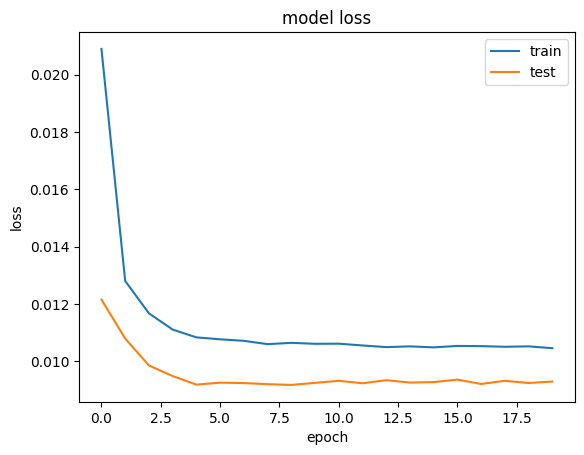

794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step
Test RMSE: 0.621


In [14]:

model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
#    model.add(LSTM(70))
#    model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')



# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=70, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 7))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

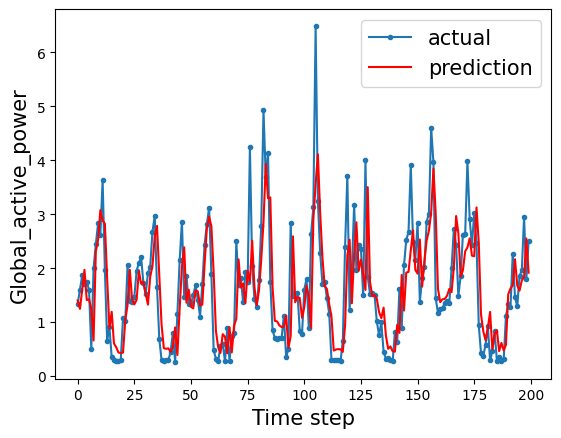

In [15]:
## time steps, every step is one hour (you can easily convert the time step to the actual time index)
## for a demonstration purpose, I only compare the predictions in 200 hours. 

aa=[x for x in range(200)]
plt.plot(aa, inv_y[:200], marker='.', label="actual")
plt.plot(aa, inv_yhat[:200], 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()